iteration #: 0001 cost= 10.870491982 distance_factor= -0.11877457 fare_offset= -0.010025568
iteration #: 0002 cost= 10.856159210 distance_factor= -0.11877457 fare_offset= -0.047374725
iteration #: 0003 cost= 10.843896866 distance_factor= -0.11877457 fare_offset= -0.08188549
iteration #: 0004 cost= 10.833400726 distance_factor= -0.11877457 fare_offset= -0.11377353
iteration #: 0005 cost= 10.824416161 distance_factor= -0.11877457 fare_offset= -0.1432382
iteration #: 0006 cost= 10.816725731 distance_factor= -0.11877457 fare_offset= -0.17046367
iteration #: 0007 cost= 10.810140610 distance_factor= -0.11877457 fare_offset= -0.19562
iteration #: 0008 cost= 10.804498672 distance_factor= -0.11877457 fare_offset= -0.2188646
iteration #: 0009 cost= 10.799666405 distance_factor= -0.11877457 fare_offset= -0.2403427
iteration #: 0010 cost= 10.795523643 distance_factor= -0.11877457 fare_offset= -0.2601886
Optimization Finished!
Trained cost= 10.795524 distance_factor= -0.11877457 fare_offset= -0.260

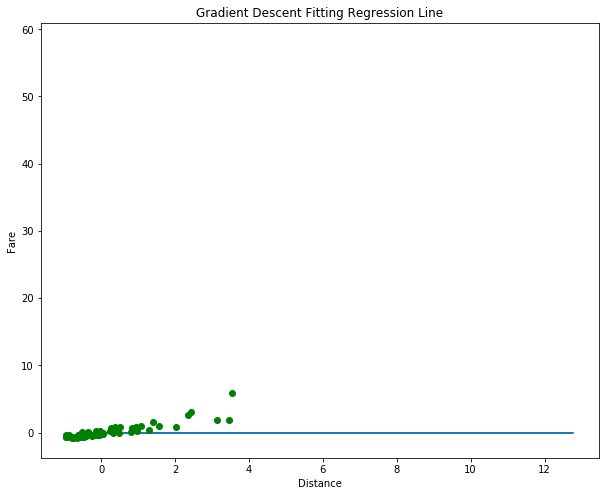

In [71]:
###### Deep Learning with Python and Tensor Flow - Kaggle Competition -predict fare - Sandeep Kanao
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#Adjust iterations
num_train_samples = 100
num_training_iter = 10

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

# you need to normalize values to prevent under/overflows.
def normalize(array):
    return (array - array.mean()) / array.std()

#print(haversine(-73.844311, 40.721319, -73.84161, 40.712278))

df = pd.read_csv('data/train-smallest.csv')

#distance from source to desination
distance_ = np.array([])

#fare from source to d
fare_  = np.array([])
for index, data in df.iterrows():
    distance_ = np.append(distance_,haversine(data['pickup_longitude'], data['pickup_latitude'], data['dropoff_longitude'], data['dropoff_latitude']))
    fare_ = np.append(fare_,data['fare_amount'])
   
                
#print(data)
distance_ = np.nan_to_num(distance_)
fare_ = np.nan_to_num(fare_)
df = pd.DataFrame({'Distance': distance_,  'Fare': fare_    })

# Plot generated Distance and fare 
#plt.plot(df['Distance'], df['Fare'], "bx")  # bx = blue x
#plt.ylabel("Fare")
#plt.xlabel("Distance")
#plt.show()

# define training data
train_distance_norm = normalize(distance_)
train_fare_norm = normalize(fare_)

#  Set up the TensorFlow placeholders that get updated as we descend down the gradient
tf_distance = tf.placeholder("float", name="distance_size")
tf_fare = tf.placeholder("float", name="fare")

# Define the variables holding the distance_factor and fare we set during training.  
# We initialize them to some random values based on the normal distribution.
tf_distance_factor = tf.Variable(np.random.randn(), name="distance_factor")
tf_fare_offset = tf.Variable(np.random.randn(), name="fare_offset")

# 2. Define the operations for the predicting values - predicted price = (distance_factor/fare ) + fare_offset
#  Notice, the use of the tensorflow add and multiply functions.  These add the operations to the computation graph,
#  AND the tensorflow methods understand how to deal with Tensors.  Therefore do not try to use numpy or other library 
#  methods.


tf_fare_pred = tf.add(tf.divide(tf_distance, tf_fare), tf_fare_offset)

# 3. Define the Loss Function (how much error) - Mean squared error
tf_cost = tf.reduce_sum(tf.pow(tf_fare_pred-tf_fare, 2))/(2*num_train_samples)

# Optimizer learning rate.  The size of the steps down the gradient
learning_rate = 0.1

# 4. define a Gradient descent optimizer that will minimize the loss defined in the operation "cost".
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(tf_cost)

#ssk
# Session
sess = tf.InteractiveSession()
display_every = 1

# Init
sess.run(tf.global_variables_initializer())

#ssk
fit_distance_factor = []
fit_fare_offsets = []
fit_plot_idx = 0
# Python Deep Learning Data Science - Sandeep Kanao
# 

# keep iterating the training data
for iteration in range(num_training_iter):

    # Fit all training data
    for (x, y) in zip(train_distance_norm, train_fare_norm):
        sess.run(optimizer, feed_dict={tf_distance: x, tf_fare: y})

    # Display current status
    if (iteration + 1) % display_every == 0:
        c = sess.run(tf_cost, feed_dict={tf_distance: train_distance_norm, tf_fare:train_fare_norm})
        print("iteration #:", '%04d' % (iteration + 1), "cost=", "{:.9f}".format(c), \
            "distance_factor=", sess.run(tf_distance_factor), "fare_offset=", sess.run(tf_fare_offset))
        # Save the fit size_factor and price_offset to allow animation of learning process
        #fit_distance_factor[fit_plot_idx] = sess.run(tf_distance_factor)
        #fit_fare_offsets[fit_plot_idx] = sess.run(tf_fare_offset)
        #fit_plot_idx = fit_plot_idx + 1

print("Optimization Finished!")
training_cost = sess.run(tf_cost, feed_dict={tf_distance: train_distance_norm, tf_fare: train_fare_norm})
print("Trained cost=", training_cost, "distance_factor=", sess.run(tf_distance_factor), "fare_offset=", sess.run(tf_fare_offset), '\n')

# 
# Plot another graph that animation of how Gradient Descent sequentually adjusted size_factor and price_offset to 
# find the values that returned the "best" fit line.
fig, ax = plt.subplots()
line, = ax.plot(distance_, fare_)

plt.rcParams["figure.figsize"] = (10,8)
plt.title("Gradient Descent Fitting Regression Line")
plt.ylabel("Fare")
plt.xlabel("Distance")
plt.plot(train_distance_norm, train_fare_norm, 'go', label='Training data')
#plt.plot(test_house_size, test_house_price, 'mo', label='Testing data')

def animate(i):
    line.set_xdata(train_distance_norm * train_distance_std + train_distance_mean)  # update the data
    line.set_ydata((fit_distance_factor[i] * train_distance_norm + fit_fare_offsets[i]) * train_fare_std + train_fare_mean)  # update the data
    return line,

 # Init only required for blitting to give a clean slate.
def initAnim():
    line.set_ydata(np.zeros(shape=train_fare_norm.shape[0])) # set y's to 0
    return line,

ani = animation.FuncAnimation(fig, animate, frames=np.arange(0, fit_plot_idx), init_func=initAnim,
                             interval=1000, blit=True)

plt.show() 